# Nonlocality Optimization in the Bilocal Scenario

This notebook considers the bilocal Bell inequalities described in  [https://arxiv.org/abs/1112.4502](https://arxiv.org/abs/1112.4502).
These inequalities pertain to a simple tripartite network known as the bilocal scenario:

<div>
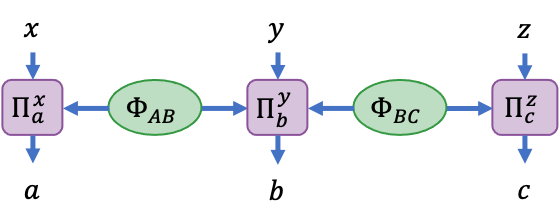
</div>

<!-- ![](images/bilocal_scenario.png) -->

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

import context
from QNetOptimizer.gradient_descent import gradient_descent

## Binary Inputs and Outputs

Consider a bilocal scenario with inputs and outputs $x,y,z,a,b,c\in\{0,1\}$.
The correlator is then defined as

$$
\langle A_x B_y C_z \rangle_{P_{22}} := \sum_{a,b,c}(-1)^{a+b+c}P_{22}(a,b,c|x,y,x).
$$

The following linear combinations will be useful:

$$
I_{22} := \frac{1}{4}\sum_{x,z\in\{0,1\}}\langle A_x B_0 C_z\rangle_{P_{22}}, \quad \text{and}
$$

$$
J_{22} := \frac{1}{4}\sum_{x,z\in\{0,1\}}(-1)^{x+z}\langle A_x B_1 C_z\rangle_{P_{22}}.
$$

The non-linear bi-local Bell inequality is then expressed as $\sqrt{|I_{22}|} + \sqrt{|J_{22}|} \leq 1.$

In [2]:
# The bilocal scenario requires 4 qubits ["a","b0","b1",c]
dev = qml.device("default.qubit", wires=["a","b0","b1","c"])

@qml.qnode(dev)
def real_bilocal_measurement_circuit(a_measurement, b_measurement, c_measurement):  
    """
    Ansatz circuit where maximally entangled bipartite states are prepared and
    measurents are free to rotate about the y-axis.
    In this model, all quantum states real.
    This scenario considers binary inputs and outputs for all parties.

    Args:
        a_measurement (float) : 1 rotation angle of Alice's measurement
        b_measurement (array[float]) : 2 rotation angles of Bob's 2-qubit measurement 
        c_measurement (float) : 1 rotation angle of Charlie's measurement
    """
    # prepare entanglement between Alice and Bob
    qml.Hadamard(wires="a")
    qml.CNOT(wires=["a", "b0"])
    
    # prepare entanglement between Bob and Charlie
    qml.Hadamard(wires="c")
    qml.CNOT(wires=["c","b1"])
    
    # single qubit measurement for Alice and Charlie
    qml.RY(a_measurement, wires="a")
    qml.RY(c_measurement, wires="c")
    
    # 2-qubit measurement for Bob
    qml.RY(b_measurement[0], wires="b0")
    qml.RY(b_measurement[1], wires="b1")

    return qml.expval(qml.PauliZ("a") @ qml.PauliZ("b0") @ qml.PauliZ("b1") @ qml.PauliZ("c"))

@qml.qnode(dev)
def bilocal22_circuit(ab_state, bc_state, a_measurement, b_measurement, c_measurement):
    """
    Ansatz circuit where maximally entangled bipartite states are prepared and
    measurents are free to rotate about the y-axis.
    In this model, all quantum states real.
    This scenario considers binary inputs and outputs for all parties.

    Args:
        ab_state (array[float]) : 15 rotation angles for the 2-qubit entangled state for alice and bob
        bc_state (array[float]) : 15 rotation angles for the 2-qubit entangled state for alice and charlie
        a_measurement (array[float]) : 3 rotation angls of Alice's measurement
        b_measurement (array[float]) : 15 rotation angles of Bob's 2-qubit measurement 
        c_measurement (array[float]) : 3 rotation angles of Charlie's measurement
    """
    
    qml.templates.subroutines.ArbitraryUnitary(ab_state, ["a","b0"])
    qml.templates.subroutines.ArbitraryUnitary(bc_state, ["b1","c"])
    
    qml.templates.subroutines.ArbitraryUnitary(a_measurement, ["a"])
    qml.templates.subroutines.ArbitraryUnitary(b_measurement, ["b0","b1"])
    qml.templates.subroutines.ArbitraryUnitary(c_measurement, ["c"])

    return qml.expval(qml.PauliZ("a") @ qml.PauliZ("b0") @ qml.PauliZ("b1") @ qml.PauliZ("c"))

In [3]:
def real_bilocal_measurement_settings():
    """
    Returns an array containing randomized tensors containing input values for
    `real_bilocal_measurement_circuit()`.
    """
    return [
        2*np.pi*np.random.random((2, 1)) - np.pi,
        2*np.pi*np.random.random((2, 2)) - np.pi,
        2*np.pi*np.random.random((2, 1)) - np.pi
    ]

def bilocal22_settings():
    """
    Returns an array containing randomized tensors containing input values for
    `bilocal22_circuit()`.
    """
    return [
        2*np.pi*np.random.random((1, 15)) - np.pi,
        2*np.pi*np.random.random((1, 15)) - np.pi,
        2*np.pi*np.random.random((2, 3)) - np.pi,
        2*np.pi*np.random.random((2, 15)) - np.pi,
        2*np.pi*np.random.random((2, 3)) - np.pi
    ]

In [4]:
def real_bilocal22_cost(settings):
    """
    Applies the bilocality inequality as a cost function with respect to the `real_bilocal_measurement_circuit()`.
    """
    I22_run1 = real_bilocal_measurement_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][0]
    )
    I22_run2 = real_bilocal_measurement_circuit(
        settings[0][1],
        settings[1][0],
        settings[2][0]
    )
    I22_run3 = real_bilocal_measurement_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][1]
    )
    I22_run4 = real_bilocal_measurement_circuit(
        settings[0][1],
        settings[1][0],
        settings[2][1]
    ) 
    I22 = (I22_run1 + I22_run2 + I22_run3 + I22_run4)/4
    
    J22_run1 = real_bilocal_measurement_circuit(
        settings[0][0],
        settings[1][1],
        settings[2][0]
    )
    J22_run2 = real_bilocal_measurement_circuit(
        settings[0][1],
        settings[1][1],
        settings[2][0]
    )
    J22_run3 = real_bilocal_measurement_circuit(
        settings[0][0],
        settings[1][1],
        settings[2][1]
    )
    J22_run4 = real_bilocal_measurement_circuit(
        settings[0][1],
        settings[1][1],
        settings[2][1]
    )
    J22 = (J22_run1 - J22_run2 - J22_run3 + J22_run4)/4

    return -1*(np.sqrt(abs(I22)) + np.sqrt(abs(J22)))

def bilocal22_cost(settings):
    """
    Applies the bilocality inequality as a cost function with respect to the `bilocal22_circuit()`.
    """
    I22_run1 = bilocal22_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][0],
        settings[3][0],
        settings[4][0]
    )
    I22_run2 = bilocal22_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][1],
        settings[3][0],
        settings[4][0]
    )
    I22_run3 = bilocal22_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][0],
        settings[3][0],
        settings[4][1]
    )
    I22_run4 = bilocal22_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][1],
        settings[3][0],
        settings[4][1]
    ) 
    I22 = (I22_run1 + I22_run2 + I22_run3 + I22_run4)/4
    
    J22_run1 = bilocal22_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][0],
        settings[3][1],
        settings[4][0]
    )
    J22_run2 = bilocal22_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][1],
        settings[3][1],
        settings[4][0]
    )
    J22_run3 = bilocal22_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][0],
        settings[3][1],
        settings[4][1]
    )
    J22_run4 = bilocal22_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][1],
        settings[3][1],
        settings[4][1]
    )
    J22 = (J22_run1 - J22_run2 - J22_run3 + J22_run4)/4

    return -1*(np.sqrt(abs(I22)) + np.sqrt(abs(J22)))

In [5]:
# initial settings
settings = real_bilocal_measurement_settings()
(final_score, final_settings, scores, samples, settings_history) = gradient_descent(real_bilocal22_cost, settings)

print(final_score)
print(final_settings)

iteration :  0 , score :  0.8287896828532377
settings :
 [array([[0.99390753],
       [2.21376404]]), array([[-1.30783492, -3.04987402],
       [ 1.9760275 ,  0.68197442]]), array([[-0.64819532],
       [-1.48738911]])] 

iteration :  25 , score :  1.3495171678406535
settings :
 [array([[0.76667972],
       [2.08966572]]), array([[-1.52553888, -3.6785086 ],
       [ 2.54505759,  0.70306683]]), array([[-0.13845577],
       [-1.38958649]])] 

iteration :  50 , score :  1.4031498916528684
settings :
 [array([[0.65411436],
       [2.10515703]]), array([[-1.66286577, -3.80675037],
       [ 2.77945854,  0.77156229]]), array([[-0.0144054 ],
       [-1.45389056]])] 

iteration :  75 , score :  1.4123662142769016
settings :
 [array([[0.60610704],
       [2.12562965]]), array([[-1.72872522, -3.84793628],
       [ 2.87285268,  0.80976276]]), array([[ 0.02618216],
       [-1.49149268]])] 

iteration :  100 , score :  1.4139082830939962
settings :
 [array([[0.58775616],
       [2.13736674]]), array

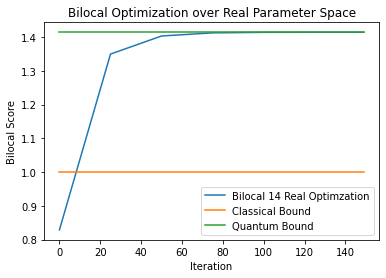

In [6]:
# Plot the score of the Bell inequality
plt.plot(samples, scores, label = r"Bilocal 14 Real Optimzation")
plt.plot(samples, [1]*len(samples), label = "Classical Bound")
plt.plot(samples, [2*np.sqrt(1/2)]*len(samples), label = "Quantum Bound")
plt.title(r"Bilocal Optimization over Real Parameter Space")
plt.xlabel("Iteration")
plt.ylabel(r"Bilocal Score")
plt.legend()
plt.show()

In [7]:
# initial settings
settings = bilocal22_settings()
(final_score, final_settings, scores, samples, settings_history) = gradient_descent(bilocal22_cost, settings)

print(final_score)
print(final_settings)

iteration :  0 , score :  0.43289914160448073
settings :
 [array([[ 2.85509951, -0.38361342, -2.28022965, -1.43163701,  1.69572725,
        -0.24472482,  1.73205315, -3.06421283,  2.45942876,  2.25223713,
        -1.6459261 , -1.27365973,  1.76932666, -0.3845027 ,  0.53032242]]), array([[-3.09946252,  1.12658293,  2.91569257,  2.27451429, -2.07923591,
        -0.28632268, -0.87098708,  2.11637172, -0.54829014, -0.9067977 ,
         0.94114952, -1.2349244 ,  0.08634786,  0.99903459,  2.78147511]]), array([[ 0.23524281,  2.91384709,  2.44495017],
       [ 1.96745743,  1.44452515, -2.83549307]]), array([[-0.50031933,  1.22104807, -3.10012451, -0.27548306,  3.07169768,
        -1.59243589, -2.70644143,  0.70357055, -2.61495804, -1.35796981,
        -2.81783051,  1.00619867,  1.68083924,  1.94404513, -2.27620492],
       [-0.98491185, -0.36507132,  0.02616907, -2.57060087,  1.27751797,
         0.7000518 ,  3.16508977, -2.39468232, -2.34756563,  0.69245108,
         1.92267062,  2.02548635,

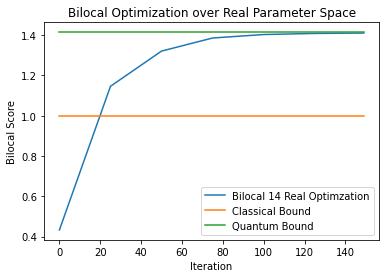

In [8]:
# Plot the score of the Bell inequality
plt.plot(samples, scores, label = r"Bilocal 14 Real Optimzation")
plt.plot(samples, [1]*len(samples), label = "Classical Bound")
plt.plot(samples, [2*np.sqrt(1/2)]*len(samples), label = "Quantum Bound")
plt.title(r"Bilocal Optimization over Real Parameter Space")
plt.xlabel("Iteration")
plt.ylabel(r"Bilocal Score")
plt.legend()
plt.show()

## Bob has a 1 Input and 4 Outputs

This scenario represents the case where Bob performs a complete Bell measurement on the two-qubit states.




In [9]:
# The bi-local scenario requires 4 qubits ["a","b0","b1",c]
dev = qml.device("default.qubit", wires=["a","b0","b1","c"])

@qml.qnode(dev)
def real_bilocal14_measurement_circuit(a_measurement, b_measurement, c_measurement):  
    """
    Ansatz circuit where maximally entangled bipartite states are prepared and
    measurents are free to rotate about the y-axis.
    In this model, all quantum states real.
    This scenario considers binary inputs and outputs for all parties.

    Args:
        a_measurement (float) : 1 rotation angle of Alice's measurement
        c_measurement (float) : 1 rotation angle of Charlie's measurement
    """
    # prepare entanglement between Alice and Bob
    qml.Hadamard(wires="a")
    qml.CNOT(wires=["a", "b0"])
    
    # prepare entanglement between Bob and Charlie
    qml.Hadamard(wires="c")
    qml.CNOT(wires=["c","b1"])
    
    # single qubit measurement for Alice and Charlie
    qml.RY(a_measurement, wires="a")
    qml.RY(c_measurement, wires="c")
    
    # 2-qubit measurement for Bob

    qml.CNOT(wires=["b0","b1"])    
    qml.RY(b_measurement[0], wires="b0")
    
    qml.RY(b_measurement[1], wires="b1")
    
    return qml.probs(wires=["a","b0","b1","c"])

In [10]:
def real_bilocal14_measurement_settings():
    """
    Returns an array containing randomized tensors containing input values for
    `real_bilocal_measurement_circuit()`.
    """
    return [
        2*np.pi*np.random.random((2, 1)) - np.pi,
        2*np.pi*np.random.random((1, 2)) - np.pi,
        2*np.pi*np.random.random((2, 1)) - np.pi
    ]
def real_bilocal14_zero_settings():
    return [
        np.zeros((2, 1)),
        np.zeros((1, 2)),
        np.zeros((2, 1))
    ]

The bilocal correlator is defined:

$$
\langle A_x B^y C_z \rangle_{P_{14}} := \sum_{a,b_0 b_1,c}(-1)^{a+b_y+c}P_{14}(a,b_0 b_1,c|x,z)
$$


In [11]:
def bilocal14_correlator(probs,y):
    probs14 = np.reshape(probs,(2,2,2,2))

    correlator = 0
    for a in [0,1]:
        for b0 in [0,1]:
            for b1 in [0,1]:
                for c in [0,1]:
                    b = b1 if y == 1 else b0
                    correlator += (-1)**(a + b + c)*probs14[a,b0,b1,c]

    return correlator

The Bilocal Bell inequality is expressed as $\sqrt{|I_{14}|} + \sqrt{|J_{14}|} \leq 1$, where

$$
I_{14} := \frac{1}{4}\sum_{x,z\in 0,1}\langle A_x B^0 C_z\rangle_{P_{14}}, \quad \text{and}
$$

$$
J_{14} := \frac{1}{4}\sum_{x,z \in 0,1}(-1)^{x+z}\langle A_x B^1 C_z \rangle_{P_{14}}.
$$

We write this as a cost function.

In [12]:
def bilocal14_cost(settings):
    
    I_14 = 0
    J_14 = 0
    for (x,z) in [(0,0),(0,1),(1,0),(1,1)]:    
        probs = real_bilocal14_measurement_circuit(settings[0][x],settings[1][0],settings[2][z])
                
        I_14 += bilocal14_correlator(probs,0)
        J_14 += (-1)**(x+z) * bilocal14_correlator(probs,1)
    
    return -(np.sqrt(abs(I_14/4)) + np.sqrt(abs(J_14/4)))

The optimal circuit is shown below the cost is about $-1.414$.

In [13]:
opt_settings = [[[np.pi/4], [3*np.pi/4]], [[-np.pi/2,0]], [[3*np.pi/4], [np.pi/4]]]
bilocal14_cost(opt_settings)

tensor(-1.41421356, requires_grad=True)

Now we optimize against the cost function with gradient descent.

In [14]:
settings = real_bilocal14_measurement_settings()
(final_score, final_settings, scores, samples, settings_history) = gradient_descent(bilocal14_cost, settings)

print(final_score)
print(final_settings)

iteration :  0 , score :  0.43687319873135533
settings :
 [array([[-0.73252164],
       [-0.16697474]]), array([[ 2.62090345, -1.03128894]]), array([[-1.11312663],
       [ 2.74666002]])] 

iteration :  25 , score :  1.1142729676960328
settings :
 [array([[-1.61268328],
       [-0.37444247]]), array([[ 2.11487751, -0.55760757]]), array([[-1.08555992],
       [ 3.36809737]])] 

iteration :  50 , score :  1.3599044810510463
settings :
 [array([[-2.07237157],
       [-0.57607174]]), array([[ 1.80165682, -0.24194607]]), array([[-0.95327605],
       [ 3.71973392]])] 

iteration :  75 , score :  1.4051420296567763
settings :
 [array([[-2.24659811],
       [-0.69284586]]), array([[ 1.66498663, -0.09978664]]), array([[-0.86167434],
       [ 3.84891345]])] 

iteration :  100 , score :  1.4127110621796826
settings :
 [array([[-2.31269472],
       [-0.74659189]]), array([[ 1.60906104, -0.04072902]]), array([[-0.81767234],
       [ 3.8963797 ]])] 

iteration :  125 , score :  1.4139650520200697
se

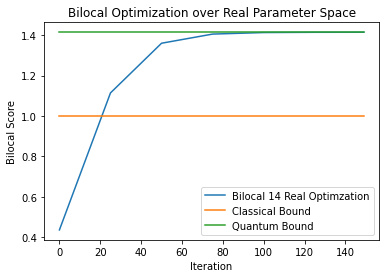

In [15]:
# Plot the score of the Bell inequality
plt.plot(samples, scores, label = r"Bilocal 14 Real Optimzation")
plt.plot(samples, [1]*len(samples), label = "Classical Bound")
plt.plot(samples, [2*np.sqrt(1/2)]*len(samples), label = "Quantum Bound")
plt.title(r"Bilocal Optimization over Real Parameter Space")
plt.xlabel("Iteration")
plt.ylabel(r"Bilocal Score")
plt.legend()
plt.show()

Now we'll verify our cost function against the experimental data published with https://advances.sciencemag.org/content/3/4/e1602743

In [16]:
# experimental probs x,y, https://advances.sciencemag.org/content/advances/suppl/2017/04/24/3.4.e1602743.DC1/1602743_SM.pdf
probs00 = np.array([
    0.0381, 0.0039, 0.0980, 0.0973,
    0.0638, 0.0687, 0.0130, 0.0846,
    0.0060, 0.0356, 0.0941, 0.1470,
    0.0691, 0.0652, 0.1072, 0.0085
])

probs01 = np.array([
    0.0238, 0.0217, 0.1599, 0.0202,
    0.0173, 0.1144, 0.0491, 0.0530,
    0.0220, 0.0242, 0.0195, 0.2068,
    0.1198, 0.0112, 0.0780, 0.0592
])

probs10 = np.array([
    0.0206, 0.0166, 0.1692, 0.0282,
    0.0174, 0.1153, 0.0571, 0.0542,
    0.0181, 0.0268, 0.0206, 0.2137,
    0.1085, 0.0108, 0.0716, 0.0513
])

probs11 = np.array([
    0.0346, 0.0036, 0.0784, 0.1020,
    0.0556, 0.0809, 0.0125, 0.0952,
    0.0046, 0.0381, 0.1077, 0.1251,
    0.0656, 0.0656, 0.1209, 0.0096
])

In [17]:
I = 0
J = 0

I += bilocal14_correlator(probs11,0)
I += bilocal14_correlator(probs01,0)
I += bilocal14_correlator(probs10,0)
I += bilocal14_correlator(probs00,0)

J += bilocal14_correlator(probs11,1)
J += -1*bilocal14_correlator(probs01,1)
J += -1*bilocal14_correlator(probs10,1)
J += bilocal14_correlator(probs00,1)

B = np.sqrt(abs(I/4)) + np.sqrt(abs(J/4))
B

tensor(1.24575496, requires_grad=True)